


<h2>Download Images and Segmentations - Tutorial</h2>

You may also want to perform your own image analysis from the raw imagery for detecting interesting substructures. For this, you may want to access the EM images and/or the segmentation masks for different objects. This notebook shows you examples on how to perform the following using two methods:

- Method 1: Using cloud volume directly to download EM images and segmentations
- Method 2: Using the imageryclient to download EM images and segmentations

<h3> Prerequisites:</h3>

To run this notebook please make sure to have Cloudvolume and Imageryclient installed

<h2>Basic Imports</h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from caveclient import CAVEclient

<h2>Set Image Sources </h2> 

In [2]:
client = CAVEclient('minnie65_public_v117')



In [3]:
img_source = client.info.image_source()
seg_source = client.info.segmentation_source()

<h2> Method 1: Using CloudVolume to download images </h2>


In [4]:
import cloudvolume

<h3>Download and Looking at an Image</h3>

In [5]:
#Initialize cloudvolume connection
img_cv = cloudvolume.CloudVolume(img_source, use_https=True)

In [6]:
#Look at the data bounds
img_cv.bounds, img_cv.resolution

(Bbox([13824, 13824, 14816],[226816, 194048, 27904], dtype=int32),
 Vec(8,8,40, dtype=int64))

In [7]:
#Download
img = img_cv[70000:70000+500, 70000:70000+500, 15000:15001]


Shard Indices: 1it [00:00,  2.00it/s]
Minishard Indices: 4it [00:00,  7.86it/s]
Decompressing: 100%|██████████| 25/25 [00:00<00:00, 462.37it/s]


In [8]:
#Check size of image
img.shape

(500, 500, 1, 1)

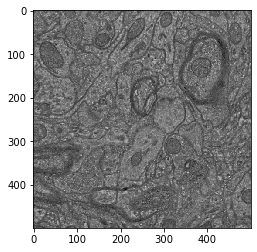

In [9]:
#Look at the image
plt.imshow(np.squeeze(img), cmap=plt.cm.gray)

<h3> Downloading and Looking at a Segmentation </h3>


In [10]:
#Initialize cloudvolume connection
seg_cv = cloudvolume.CloudVolume(seg_source, use_https=True, agglomerate=True)

In [11]:
#Look at the data bounds
seg_cv.bounds,seg_cv.resolution

(Bbox([26385, 30308, 14850],[218809, 161359, 27858], dtype=int32),
 Vec(8,8,40, dtype=int64))

In [12]:
#Download Segmentation
seg = seg_cv[70000:70000+500, 70000:70000+500, 15000:15001]
#Check shape of Image
seg.shape

Downloading: 100%|██████████| 6/6 [00:01<00:00,  5.67it/s]


(500, 500, 1, 1)

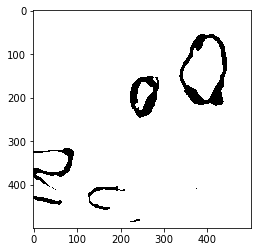

In [13]:
#Look at the image
plt.imshow(np.squeeze(seg), cmap=plt.cm.gray)

<h3> Use Remapping </h3>

Now because each pixel contains the ID of the object, 
visualizing this as a normal image doesn't make sense
fastremap can help you map these large IDs to smaller ones
so visualization makes more sense as an image

In [14]:
import fastremap
# may be much faster than np.unique
uniq, cts = fastremap.unique(seg, return_counts=True)
#list of ids in this cutout
uniq


array([                 0, 864691134728892395, 864691135012455926,
       864691133773259509, 864691134728973035, 864691133773260021,
       864691135114999652, 864691134202205363, 864691134728988395,
       864691134967460964, 864691135808702904, 864691134202205107,
       864691135753667789, 864691135407325385, 864691134728986603,
       864691136121308029, 864691133954733929, 864691135780842576,
       864691135413928946, 864691136099052625, 864691135269929637,
       864691133375709723, 864691135715889627, 864691133773268981,
       864691137131677505, 864691134728921579, 864691136020835479,
       864691134728898283, 864691135808540600, 864691135379821630,
       864691135114997860, 864691132923931809, 864691135847952465,
       864691135754106796, 864691134728981739, 864691135810202552,
       864691132835734770, 864691134728926955, 864691134967619684,
       864691135477073104, 864691135572799954, 864691135715511771,
       864691135855709486, 864691135092951652, 864691135808884

<h3>Look at remapping</h3>

In [15]:
# relabel values from 1 and refit data type
remappedseg, remapping = fastremap.renumber(seg, in_place=True)

remapping

{864691134728988907: 136,
 864691133644573787: 135,
 864691133511915522: 134,
 864691136112696957: 130,
 864691132572147277: 126,
 864691134728880107: 124,
 864691135716048347: 122,
 864691136725693156: 121,
 864691135370169918: 120,
 864691135715643355: 127,
 864691133511915266: 119,
 864691135716063963: 116,
 864691132937817527: 115,
 864691135114995044: 114,
 864691136811785326: 112,
 864691135715767515: 111,
 864691134728895723: 110,
 864691135330773054: 109,
 864691135753924268: 107,
 864691135449033714: 106,
 864691134728895979: 102,
 864691132927333568: 100,
 864691135725641023: 97,
 864691135753667789: 12,
 864691133511899394: 96,
 864691135810192312: 95,
 864691134728981739: 34,
 864691132923931809: 31,
 864691135114995556: 92,
 864691135780842576: 17,
 864691135808846520: 91,
 864691135715775707: 125,
 864691135693865170: 84,
 864691135564123602: 133,
 864691133511916290: 79,
 864691134967460964: 9,
 864691135583027652: 76,
 864691133511898114: 86,
 864691134728927723: 74,
 8

<h3>Visualize</h3>

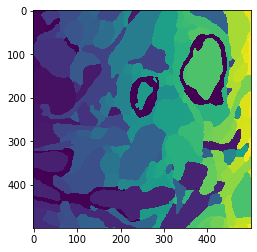

In [16]:
plt.imshow(np.squeeze(remappedseg))

In [17]:
seg.shape, img.shape

((500, 500, 1, 1), (500, 500, 1, 1))

<h2>Method 2: Using the Imagery Client </h2>

The ImageryClient can help you think less
about how to manage bounds between segmentation and images layers
when you are trying to make cutouts

In [18]:
from imageryclient import ImageryClient

<h3> Lets visualize the image and segmentation in the area
that surrounds a random synapse </h3>

In [19]:
syn_df = client.materialize.synapse_query(pre_ids = [864691135564133842], split_positions=True)
syn_num = 1
post_id =syn_df.loc[syn_num,'post_pt_root_id']
pre_id = syn_df.loc[syn_num,'pre_pt_root_id']
syn=syn_df.loc[syn_num]

In [20]:
voxel_resolution = client.materialize.get_table_metadata(client.materialize.synapse_table)['voxel_resolution']
voxel_resolution

[4.0, 4.0, 40.0]

<h3> Initialize Imagery client with image and segmentation source </h3>

In [21]:
ic=ImageryClient(image_source = img_source,
                 segmentation_source=seg_source)

<h3> Pick 5 consecutive sections centered around this synapse</h3>

This will pick out bounds with a 300 pixel (3.58*300 = 1027 nm) x,y region
and 5 sections @40 nm in z. Note that because of how slices work, for example, a lower bound of z and an upper bound of z+3 only returns the sections at z, z+1, and z+2 but is not inclusive of z+3.

In [22]:
scaling = ic.base_resolution/voxel_resolution
bounds=np.array([[syn.ctr_pt_position_x-150, syn.ctr_pt_position_y-150, syn.ctr_pt_position_z-2],
        [syn.ctr_pt_position_x+150, syn.ctr_pt_position_y+150, syn.ctr_pt_position_z+3]])/scaling


<h3>Download the cutouts</h3>

In [23]:
imgvol, segdict = ic.image_and_segmentation_cutout(bounds,
                                                   split_segmentations=True)

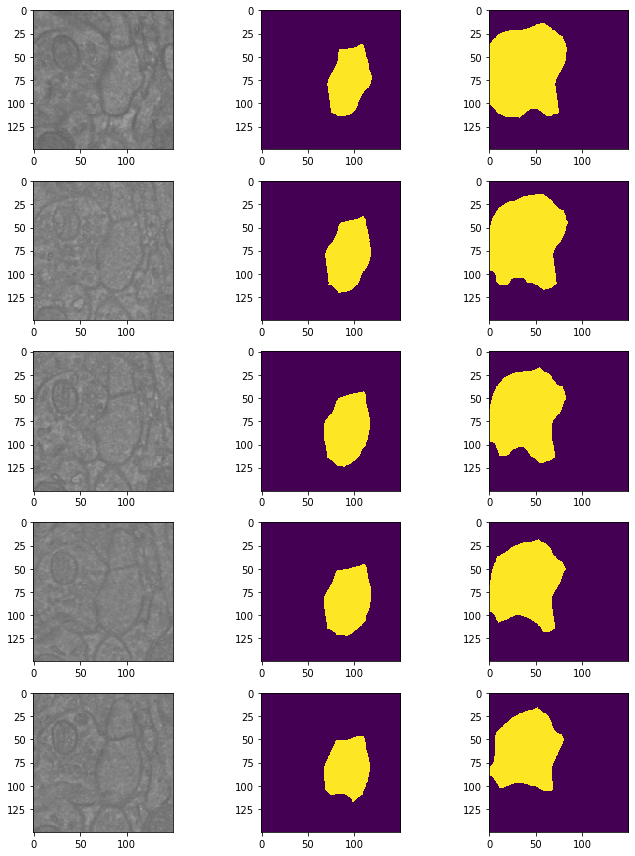

In [24]:
f ,ax = plt.subplots(5,3, figsize=(10,12))
# lets loop over z sections
for i in range(5):
    
    # plot the images in column 0
    ax[i, 0].imshow(np.squeeze(imgvol[:,:,i]),
                    cmap=plt.cm.gray,
                    vmax=255,
                    vmin=0)
    # plot the pre-synaptic mask in column 1
    ax[i, 1].imshow(np.squeeze(segdict[post_id][:,:,i]))
    # plot the post-synaptic mask in column 2
    ax[i, 2].imshow(np.squeeze(segdict[pre_id][:,:,i]))
f.tight_layout()

In [25]:
imgvol.shape

(150, 150, 5)

<h3>Save Images</h3>

This function will save a series of PNG images that are exactly the same size
so you can easily combine them as layers in Illustrator or photoshop
to make a publication quality figures

In [26]:
ic.save_image_and_segmentation_masks('synapse_test', bounds=bounds,
                                     root_ids = [pre_id, post_id],
                                     segmentation_colormap={pre_id:[255, 0,0,255], 
                                                            post_id:[0, 255, 0 ,255]})